# Figure 6: Indirect effects

In [1]:
source('../scripts/load_libraries.R')
source('../scripts/load_constants.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘lemon’


The following objects are masked from ‘package:ggplot2’:

    CoordCartesian, element_render




In [2]:
source('../scripts/load_data.R')

Rows: 17264341 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): comment_id, user_id, author_id, anonymous, first_view

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1281001 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, score, time_stamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 223737 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, num, time_stamp

ℹ Use `spec()` t

Pull in comments so we can get story_ids.

In [3]:
all_comments <- read_csv('../data/comments_cleaned.csv', 
                         col_types = list(comment_id = col_integer(),
                                          story_id = col_integer()))
head(all_comments)

comment_id,story_id,author_id,parent_id,ts
<int>,<int>,<dbl>,<dbl>,<dbl>
860550,313479,28722,860508,1308957306
842201,309234,15173,NA,1305972416
842202,309234,9349,NA,1305972722
842203,309223,15173,842157,1305972746
842207,309191,114871,842169,1305972919
842205,309234,2294,NA,1305972877


In [4]:
df <- df %>% 
  mutate(comment_id = as.integer(comment_id), user_id = as.integer(user_id))

In [5]:
users <- df %>%
  group_by(user_id) %>%
  summarise() %>%
  ungroup()

comments <- df %>%
  group_by(comment_id) %>%
  summarise() %>%
  ungroup()

stories <- df %>%
  inner_join(all_comments %>% select(comment_id, story_id)) %>%
  group_by(story_id) %>%
  summarise() %>%
  ungroup()

by_user_story <- df %>%
  inner_join(all_comments %>% select(comment_id, story_id)) %>%
  group_by(user_id, story_id) %>%
  summarise(num_anon_comments = sum(anonymous), 
            num_comments = n())

Joining, by = "comment_id"
Joining, by = "comment_id"
`summarise()` has grouped output by 'user_id'. You can override using the `.groups` argument.


In [6]:
df3 <- df_clean %>%
  inner_join(all_comments %>% select(comment_id, story_id)) %>%
  filter(!anonymous) %>%
  inner_join(
      by_user_story %>% 
      select(user_id, story_id, num_comments, num_anon_comments) %>% 
      filter(num_anon_comments <= 2)
  )

Joining, by = "comment_id"
Joining, by = c("user_id", "story_id")


100 replicates of a double-or-nothing bootstrap to get CIs

In [7]:
reps <- tibble(rep = 1:100) %>%
  group_by(rep) %>% do({
    seed <- first(.$rep)
    df3 %>%
      inner_join(users %>% sample_frac(0.5), by = 'user_id') %>%
      inner_join(stories %>% sample_frac(0.5), by = 'story_id') %>%
      group_by(num_comments, num_anon_comments) %>%
      summarise(up = mean(up), dn = mean(dn), rp = mean(rp), n = n())
  }) %>%
  ungroup()

`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'num_comments'. You can override using the `.groups` argument.
`summarise

`summarise()` has grouped output by 'num_comments', 'outcome'. You can override using the `.groups` argument.
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


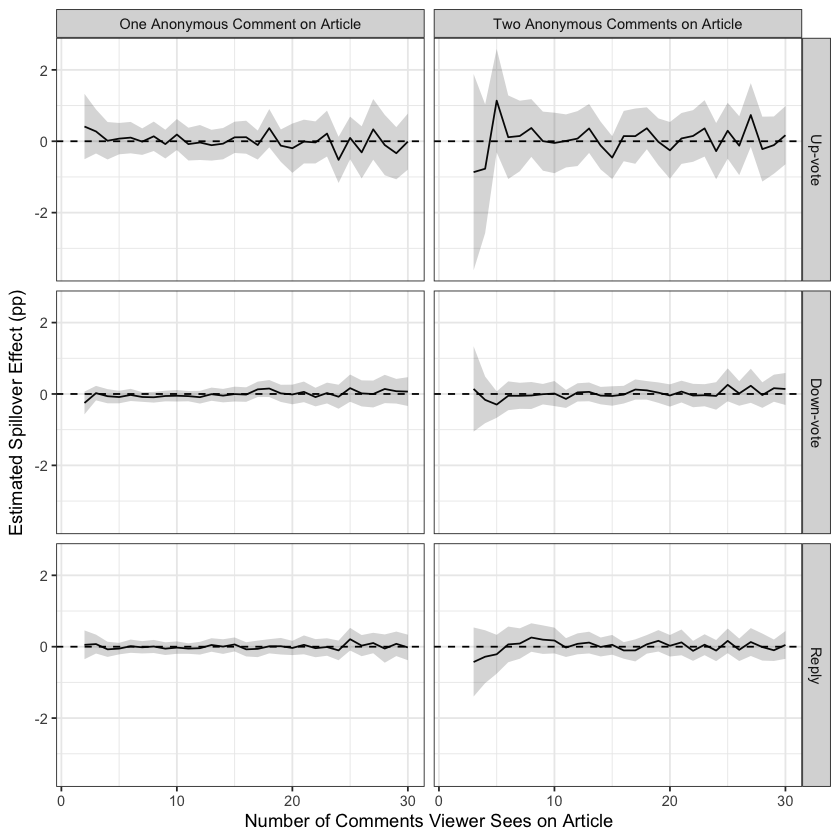

In [8]:
p <- reps %>%
  mutate(num_anon_comments = c('zero', 'one', 'two')[num_anon_comments + 1]) %>%
  gather(outcome, value, up, dn, rp) %>%
  ungroup() %>%
  select(-n) %>%
  spread(num_anon_comments, value) %>%
  filter(num_comments <= 50) %>%
  mutate(outcome = forcats::fct_relevel(factor(outcome), c('up', 'dn', 'rp')),
         outcome = forcats::fct_recode(outcome, 
                                       `Up-vote` = 'up', `Down-vote` = 'dn', `Reply` = 'rp'),
         rr.one = 100 * (one - zero),
         rr.two = 100 * (two - zero)) %>%
  select(rep, num_comments, outcome, one = rr.one, two = rr.two) %>%
  gather(treatment, value, one, two) %>%
  mutate(treatment = forcats::fct_recode(factor(treatment), 
                                         `One Anonymous Comment on Article` = 'one',
                                         `Two Anonymous Comments on Article` = 'two')) %>%
  group_by(num_comments, outcome, treatment) %>%
  filter(num_comments <= 30) %>%
  summarise(mu = mean(value), se = sd(value),
            lcl = mu - 1.96 * se, ucl = mu + 1.96 * se) %>%
  ggplot(aes(x = num_comments, y = mu)) +
  geom_line() +
  geom_ribbon(aes(ymin = lcl, ymax = ucl), alpha = 0.2) +
  #geom_line(aes(y = lcl), linetype = 'dashed') +
  #geom_line(aes(y = ucl), linetype = 'dashed') +
  facet_grid(outcome ~ treatment) +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  xlab('Number of Comments Viewer Sees on Article') +
  ylab('Estimated Spillover Effect (pp)') +
  theme_bw()
p

In [9]:
ggsave('../figures/fig-6.pdf', p, width = 5.5, height = 5)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
